## 4.1 混合ガウスモデル

### 4.1.1 モデル概要
$$
\begin{align*}
    p(y) = \int {p(y|f)p(f)\text{d}f} \\
    p(f) = \text{GP}(m(x), k(x, x'))
\end{align*}
$$

In [31]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

人工データを生成.

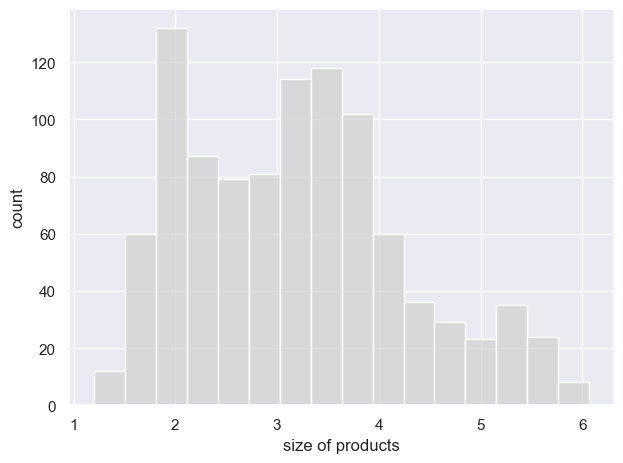

In [6]:
# 以下, 人工データの生成過程.
n_sample = 1000
components = 3

pi_list = np.array([0.3, 0.6, 0.1])
mu_list = np.array([2.0, 3.4, 5.2])
sigma_list = np.array([0.3, 0.6, 0.4])

np.random.seed(1)
latent = np.random.choice(components, size=n_sample, p=pi_list)
data = np.random.normal(mu_list[latent], sigma_list[latent])

# ヒストグラムの生成.
fig, ax = plt.subplots()
sns.histplot(data, color='lightgray', ax=ax)
ax.set_xlabel('size of products')
ax.set_ylabel('count')
plt.tight_layout()
plt.show()

In [9]:
import pymc3 as pm

n_sample = 1000
K = 3

with pm.Model() as model:
    # 混合比率
    pi = pm.Dirichlet("pi", a=np.ones(K), shape=K)

    # クラスタごとのガウス分布の平均
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K)

    # クラスタごとのガウス分布の標準偏差
    sigma = pm.HalfCauchy("sigma", beta=3, shape=K)

    # クラスタ割り当てを示す潜在変数
    z = pm.Categorical("z", p=pi, shape=n_sample)

    # 観測モデル
    x = pm.Normal("x", mu=mu[z], sigma=sigma[z], observed=data)

In [10]:
with model:
    trace = pm.sample(5000, tune=1000, chains=1, random_seed=1, return_inferencedata=True)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [sigma, mu, pi]
>CategoricalGibbsMetropolis: [z]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 499 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

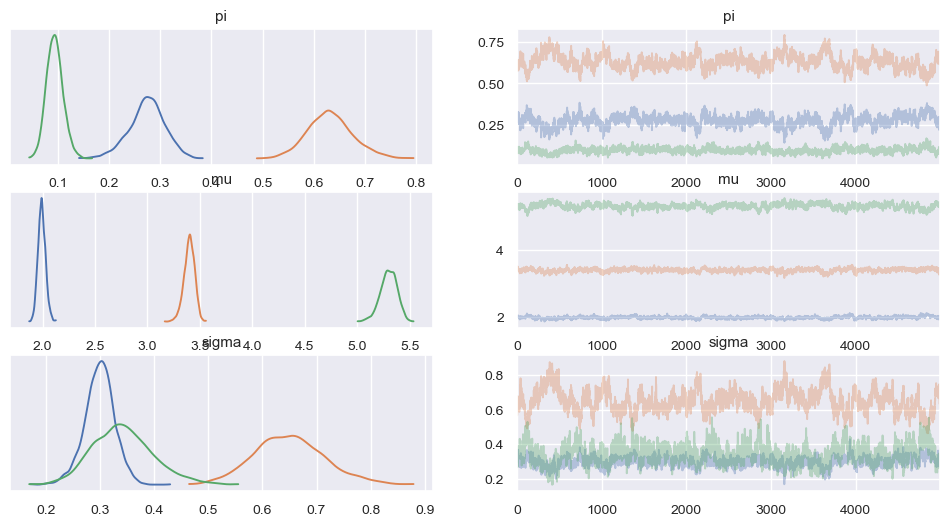

In [12]:
az.plot_trace(trace, var_names=["pi", "mu", "sigma"])

In [13]:
display(az.summary(trace, var_names=["pi", "mu", "sigma"], kind="stats"))

,mean,sd,hdi_3%,hdi_97%
pi[0],0.274,0.035,0.208,0.340
pi[1],0.632,0.044,0.545,0.713
pi[2],0.094,0.016,0.066,0.127
mu[0],1.993,0.036,1.925,2.060
mu[1],3.398,0.051,3.305,3.494
mu[2],5.299,0.079,5.161,5.453
sigma[0],0.299,0.028,0.248,0.354
sigma[1],0.650,0.065,0.532,0.780
sigma[2],0.342,0.056,0.245,0.457


In [25]:
z_samples = trace.posterior["z"][0].values

# データ点について, 各クラスタが割り当てられた回数
label_counts = np.vstack([(z_samples == i).sum(axis=0) for i in range(K)]).transpose()

# データ点が各クラスタに属する確率
label_probs = label_counts / 5000

index: 2, value: 2.244


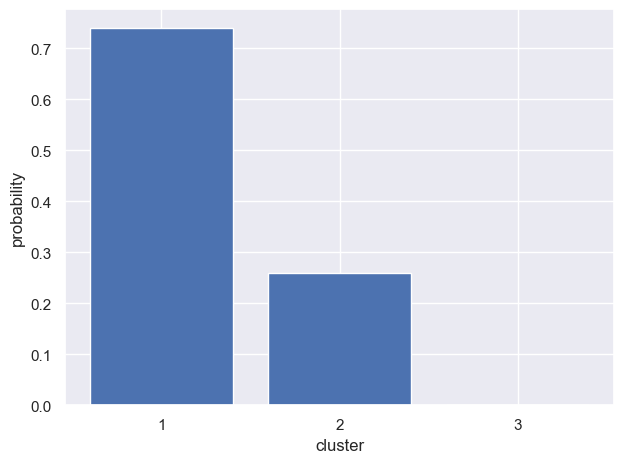

In [28]:
i = 2

print(f'index: {i}, value: {data[i]:.3f}')
plt.bar(['1', '2', '3'], label_probs[i])
plt.xlabel('cluster')
plt.ylabel('probability')
plt.tight_layout()
plt.show()

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/seaborn/distributions.py:254: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


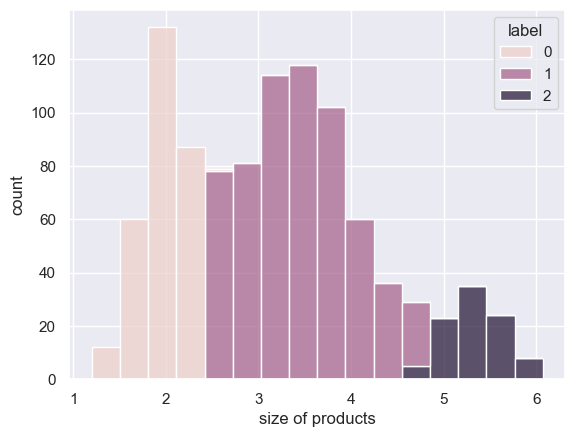

In [34]:
# 確率最大のクラスタを選択
label_preds = label_probs.argmax(axis=1)

preds = pd.DataFrame(dict(x=data, label=label_preds))
sns.histplot(preds, x="x", hue="label", multiple="stack")
plt.xlabel("size of products")
plt.ylabel("count")
plt.show()

潜在変数を周辺化する場合は以下の通り.
ただし, 周辺化しない際にはカテゴリカル分布があったため, どのクラスタに属しているかすぐに判明したが, 周辺化した場合にはすぐにはわからない.
ゆえに, 事後的にそれぞれのガウス分布に従った場合の尤度関数値を比較して最大のもののガウス分布に属するという計算が必要.

In [38]:
import pymc3 as pm

n_sample = 1000
K = 3

with pm.Model() as model:
    # 混合比率
    pi = pm.Dirichlet("pi", a=np.ones(K), shape=K)

    # クラスタごとのガウス分布の平均
    mu = pm.Normal("mu", mu=0, sigma=10, shape=K, transform=pm.transforms.ordered, testval=[1, 2, 3])

    # クラスタごとのガウス分布の標準偏差
    sigma = pm.HalfCauchy("sigma", beta=3, shape=K)

    # 観測モデル
    x = pm.NormalMixture("x", pi, mu=mu, sigma=sigma, observed=data)

In [39]:
with model:
    trace = pm.sample(5000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, mu, pi]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 33 seconds.


array([[<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

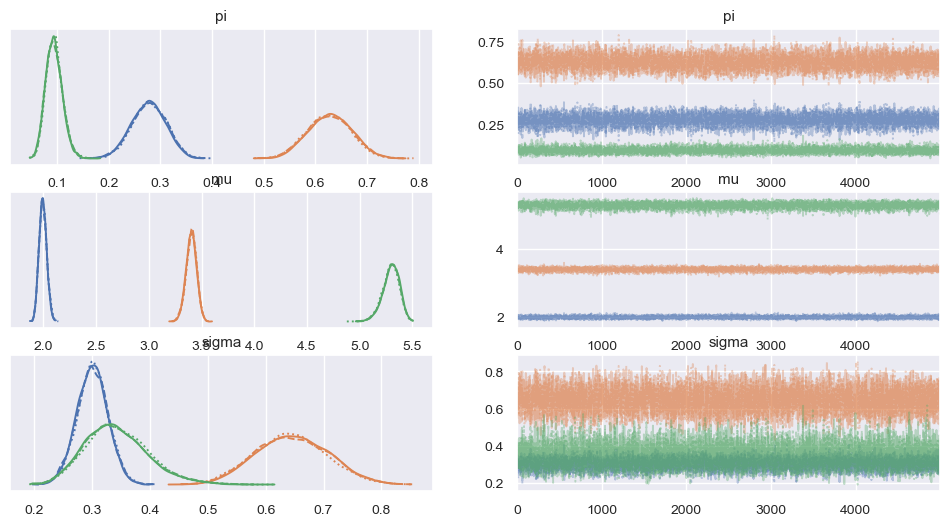

In [40]:
az.plot_trace(trace, var_names=["pi", "mu", "sigma"])

In [41]:
display(az.summary(trace, var_names=["pi", "mu", "sigma"], kind="stats"))

,mean,sd,hdi_3%,hdi_97%
pi[0],0.278,0.033,0.217,0.341
pi[1],0.628,0.042,0.551,0.706
pi[2],0.095,0.016,0.064,0.124
mu[0],1.995,0.036,1.929,2.065
mu[1],3.403,0.050,3.310,3.497
mu[2],5.296,0.079,5.147,5.442
sigma[0],0.301,0.027,0.249,0.351
sigma[1],0.645,0.062,0.525,0.755
sigma[2],0.343,0.055,0.242,0.445
